<header>
Satellites Characterization
============
</header> 
** EE-558, A Network Tour of Data Science ** <br>
** Lucas Gauchoux, Laurier Loiselle, Antoine Weber **

# Abstract

Satellites are a key part of our everyday life, from [meteorology](https://en.wikipedia.org/wiki/Weather_satellite), to [telecomunications](https://en.wikipedia.org/wiki/Communications_satellite) and [localization](https://en.wikipedia.org/wiki/GPS_satellite_blocks).
Regardless, it is hard to relate to the [vast amount](https://www.pixalytics.com/sats-orbiting-earth-2017/) of satellites above our heads.
This project aims to give details on those satellites by exploiting two large databases ([space-track.org](https://www.space-track.org/auth/login) and [SATCAT](https://celestrak.com/satcat/search.asp)).

To do so, we will provide an analysis of two main components of satellites, their [orbits](http://www.polaris.iastate.edu/EveningStar/Unit4/unit4_sub3.htm) and their [launch-site](http://space.skyrocket.de/directories/launchsites.htm).

<div style="margin: 0 auto; text-align: center; overflow: hidden;">
  <div style="float: center;">
    <a href="http://xyz.com/hello"><img src="http://3.bp.blogspot.com/-cnrj0J28mKQ/VAIvYrO6eZI/AAAAAAAAB3s/p9okiCspmnE/s1600/Satellite%2BOrbits.gif", width=200,height=200></a>
    Fig. 1: Example of orbits around earth
  </div>
</div>

This analysis will use graph processing tools to extract meaning from the datasets we use.
Our goals will be in two part:
1. Find correlations between satellites orbits to show their patterns and to distinguish the difference between the orbit types.
2. From orbital informations and qualitative data, attempt to determine the launch sites of a subset of satellites.

The first goal aims to address the need of better understanding satellite orbits by showing how subsets of satellites have very similar orbits and to show the scale of the satellite cluster orbiting above us.

The second goal aims to show how a critical part of space mission design, in part due to the cost of [orbital maneuver](https://en.wikipedia.org/wiki/Orbital_maneuver), is to place the satellites directly at or close to their desired orbit. Because of this, we will show that, if classified by their orbital parameters, satellites launched from the same institutions, mainly [NASA](https://www.nasa.gov/) and USA allied foreign countries, can be traced back to their [spaceport](https://en.wikipedia.org/wiki/Spaceport) location.

# Imports, global names and helper functions

In [1]:
%matplotlib inline

from tqdm import tqdm
import json

from numpy import pi
import numpy as np
import pandas as pd
from scipy import sparse, stats, spatial, linalg

import networkx as nx
from networkx.algorithms import community
from pygsp import graphs, filters, plotting

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import reverse_geocoder as rg

import random

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

from helpers import *
from helpers_satcat import *

# Analysis of the satellite orbits

## Data Acquisition

The dataset comes from the website [space-track.org](https://www.space-track.org/auth/login).
To extract the data, it is necessary to create an account.
Once the account created, we where able to download datasets in bulk.

From the website, we extracted datasets that we found meaningfull for the task at hand.
Those datasets are as follow:

1. ** [Satellite current TLE](Dataset/satellite_tle_current.txt): ** The [Two Line Element (TLE)](https://www.celestrak.com/NORAD/documentation/tle-fmt.asp) format describes the main satellites information.
    It provides current orbital status and position. 
    It also gives the satellite designator that can be used to extract more informations about the satellite.
    The extracted file gives the current TLE for 16731 satellites or debrits in orbit.
    The file is given in a text format, but it is standardized, so it will be easily scraped with regexes.
    A more extensive TLE dataset is provided on the website, we hitted rate limiting when downloading it, but theorically,
    it countains the TLE of all satellites since the beginning of the space age, with various degrees of precisions.
    For now we will not extract the complete historical TLE dataset, but it is an option if we want to do a more complete/complex analysis.

2. ** [Satellite in orbit info](Dataset/satellite_in_orbit_info.csv): ** This file is given in a csv format.
    It gives all the satellites currently in orbits.
    It gives the NORAD_CAT_ID, so it can easily be linked to the TLE.
    Also, it gives information on the satelitte name, the launch date and the country of launch which will be valuable in our analysis.

3. ** [Satellite statistics by country](Dataset/satellite_statistics_per_country.csv): ** This file is given in a csv format.
    It gives information per country on various metrics: the number of satellites in orbit, the number of debris, the number of rocket bodies, the same information for the decayed objects and totals per country.
    This is interesting to give a per country view of the space programs without having to scrape the other (big) datasets.

## Data Exploration

As said before we retrieved three different files from the [SpaceTrack](https://www.space-track.org) website. The most important one is the file containing the [two-line elements](https://en.wikipedia.org/wiki/Two-line_element_set). We will therefore start by exploring this one.

### Two-Line Elements

A two line element is a data format containing a list of orbital information. Those information allow us to compute the position of a satellite at a given time.
It looks like this:
    - 0 VANGUARD 2
    - 1    11U 59001A   17329.92226964 +.00000367 +00000-0 +19707-3 0  9992
    - 2    11 032.8697 323.5388 1468703 016.5820 347.7999 11.85506786164031
The first line is the name of the satellite and the following lines are the so called two line element for this satellite. The full description of each parameters can be found [here](https://en.wikipedia.org/wiki/Two-line_element_set#Format).
However we are interested in the position of satellites. In order to convert this raw data into a localisation we will use the [pyephem](https://pypi.python.org/pypi/pyephem/) library. <br>
We thus compute the longitude, latitude and elevation for each sattelite of the text file "satellite_tle_current".

In [2]:
lines_tot = read_tle('Dataset/satellite_tle_current.txt')
assert [lines_tot.count('\n') == 0]

names,long,lat,elevation_km = compute_tle_informations(lines_tot)
data = pd.DataFrame(np.transpose([names,long,lat,elevation_km]))
data.columns = ['OBJECT_NAME','Longitude [°]','Latitude [°]','Elevation [km]']

Index number 5361 is not compatible to perform computation
Index number 49563 is not compatible to perform computation


As we can see from the debug output above, some TLE were not in the right format and their position is not computable.
The retrieved data set contains now the position of all satellites that had the right format.

In [3]:
data.head()

OBJECT_NAME        Longitude [°]         Latitude [°] Elevation [km]
0    VANGUARD 1   -63.01315328238157   -26.65173623575367    950.1053125
1    VANGUARD 2   33.607191075144456   -32.25819456312109     2825.77825
2  VANGUARD R/B   158.90670062542114   1.4622271746404283    746.4226875
3  VANGUARD R/B  -117.00344908625789   12.395302654786787    2056.953375
4    VANGUARD 3  -14.979412519707317  -30.811335100669776        3271.14

In [4]:
data.OBJECT_NAME.is_unique

False

As we can see the name of the satellite are not unique and by a quick verification, they don't share the same TLE. This means that, for two satellites with the same name, we get two different positions which is inconsistent. Most of the objects having the same name have the extension "DEB". This extension means that this object is a debris of the original satellite. This is due to explosion or colision with anothoer object of the satellite. It makes sense to keep track of those object to predict future collisions with those debris for exemple. However we are interested in "real" satellites. Therefore we remove all the satellites whose object name has the extension "DEB". Moreover, we also removed all the remaining duplicates in order to use the satellite names as indexes

In [5]:
no_deb = data[["DEB" not in x for x in data.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")
no_deb.head()

OBJECT_NAME        Longitude [°]         Latitude [°] Elevation [km]
0    VANGUARD 1   -63.01315328238157   -26.65173623575367    950.1053125
1    VANGUARD 2   33.607191075144456   -32.25819456312109     2825.77825
2  VANGUARD R/B   158.90670062542114   1.4622271746404283    746.4226875
4    VANGUARD 3  -14.979412519707317  -30.811335100669776        3271.14
5    EXPLORER 7    165.9903034740197    9.845133707399345   517.82565625

We can now visualize the distibustion of those three values.

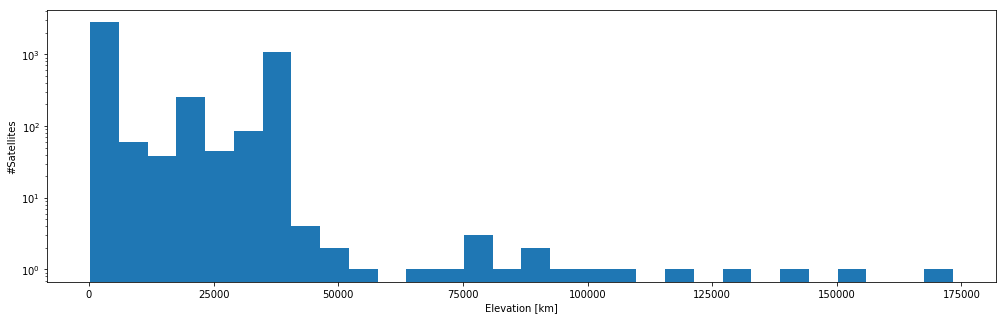

In [6]:
#no_deb["Elevation [km]"].astype("float").plot(kind="bar", bins= 30)
plt.hist(no_deb["Elevation [km]"].astype("float"), bins = 30, log=True)
plt.xlabel("Elevation [km]")
plt.ylabel("#Satellites")
plt.show()

We can observe two main peaks. One more or less representing satellites orbiting below ~4500 km and one for those orbiting around 35'000 km. The two bars corresponds to the LEO (Low Earth Orbit) and the GEO/GSO (Geosynchronous/Geostationary orbit). Between the two peaks, there is still a lot of satellites. They are called the MEO (Medium Earth Orbit). The remaining satellites higher than the GEO/GSO are called HEO (High Earth Orbit).

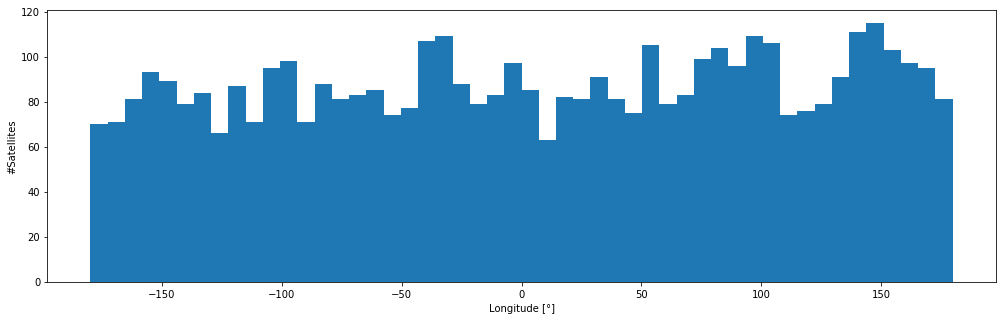

In [7]:
plt.hist(no_deb["Longitude [°]"].astype("float"), bins = 50, log=False)
plt.xlabel("Longitude [°]")
plt.ylabel("#Satellites")
plt.show()

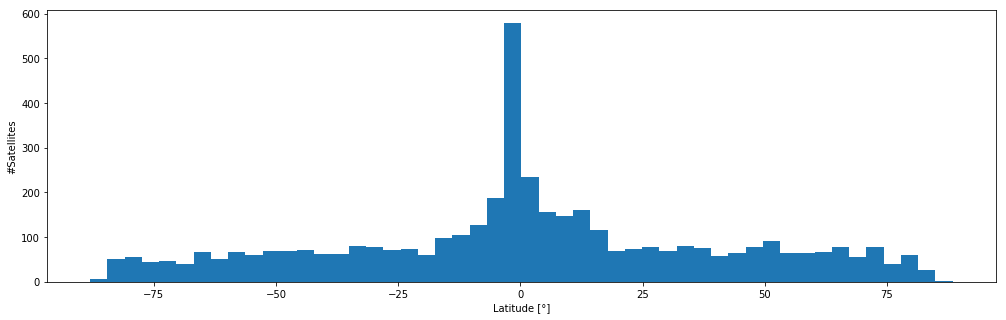

In [8]:
plt.hist(no_deb["Latitude [°]"].astype("float"), bins = 50, log=False)
plt.xlabel("Latitude [°]")
plt.ylabel("#Satellites")
plt.show()

As we can see there is a nice spread over all the possible values of longitudes. There are no peaks meaning that the satellites are uniformly distributed over all the longitude values. However it's not the case for the latitudes. Indeed, we can observe a huge peak at the 0° lattitude which corresponds to the equator. <br>
The equator is where Geostationary satellites are located. Geostationary satellites have the same period as the one from the earth and always have the same positions relatively to the ground.

### Satellites in Orbit Info

The second file that we retrieved contain aditional information for each satellites as we can see below.

In [9]:
sioi = pd.read_csv("Dataset/satellites_in_orbit_info.csv")
sioi.head()

OBJECT_ID  OBJECT_NAME  NORAD_CAT_ID COUNTRY  PERIOD  INCLINATION  APOGEE  \
0   2017-075D    CZ-2C R/B         43031     PRC   95.19        35.21   599.0   
1   2017-075C  YAOGAN-30 F         43030     PRC   96.62        35.00   604.0   
2   2017-075B  YAOGAN-30 E         43029     PRC   96.62        35.00   604.0   
3   2017-075A  YAOGAN-30 D         43028     PRC   96.62        35.00   603.0   
4  1998-067NL    OSIRIS-3U         43027      US   92.59        51.64   405.0   

   PERIGEE RCS_SIZE  RCSVALUE      LAUNCH COMMENT  
0    457.0      NaN         0  2017-11-24     NaN  
1    590.0      NaN         0  2017-11-24     NaN  
2    590.0      NaN         0  2017-11-24     NaN  
3    590.0      NaN         0  2017-11-24     NaN  
4    398.0      NaN         0  1998-11-20     NaN

We start by cleaning the dataframe before vizualizing it. We start by dropping the columns COMMENT, RCSVALUE and RCS_SIZE because they contain, most of the time, useless or no informations at all.

In [10]:
sioi = sioi.drop(["COMMENT", "RCSVALUE", "RCS_SIZE"], axis = 1)

We then remove the satellites that have duplicates and that have the DEB extension to be consistent with our previous processing on the TLE file. We also remove rows that still contain NaN values.

In [11]:
sioi = sioi[["DEB" not in x for x in sioi.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")
sioi = sioi.dropna(axis = 0)
sioi.head()

OBJECT_ID  OBJECT_NAME  NORAD_CAT_ID COUNTRY  PERIOD  INCLINATION  APOGEE  \
0   2017-075D    CZ-2C R/B         43031     PRC   95.19        35.21   599.0   
1   2017-075C  YAOGAN-30 F         43030     PRC   96.62        35.00   604.0   
2   2017-075B  YAOGAN-30 E         43029     PRC   96.62        35.00   604.0   
3   2017-075A  YAOGAN-30 D         43028     PRC   96.62        35.00   603.0   
4  1998-067NL    OSIRIS-3U         43027      US   92.59        51.64   405.0   

   PERIGEE      LAUNCH  
0    457.0  2017-11-24  
1    590.0  2017-11-24  
2    590.0  2017-11-24  
3    590.0  2017-11-24  
4    398.0  1998-11-20

We can now plot the apogee and expect a similar distribution as the elevation feature for the TLE file.

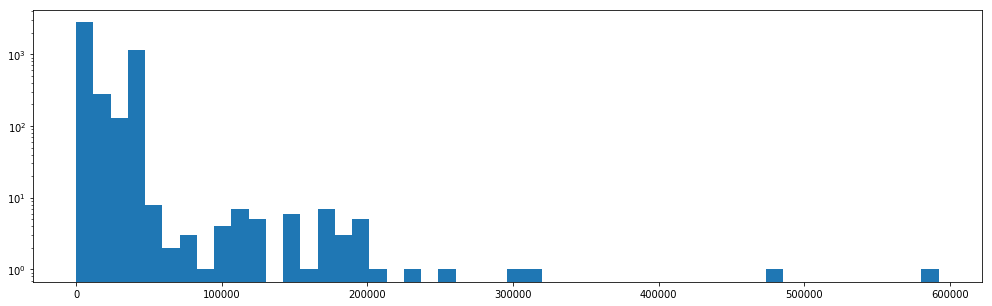

In [12]:
plt.hist(sioi.APOGEE, bins=50, log=True)
plt.show()

As we can see the two files don't seem to contains the same set of satellites. We can plot the satellites that have an apogee lower than 175'000 km to compare more precisely the two plots.

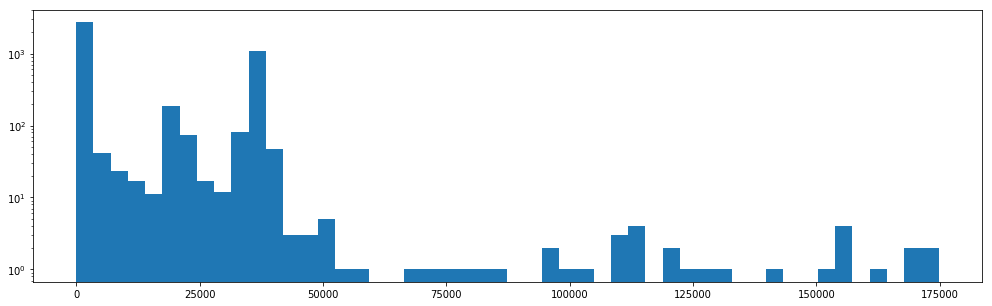

In [13]:
plt.hist(sioi.APOGEE[sioi.APOGEE < 175000], bins=50, log=True)
plt.show()

We can observe a similar distribution as the elevation. Apparently this file contains mainly informations about LEO and GEO/GSO satellites. In order to use both files in the exploitation part of the project, we will have to merge them.

We can plot the launchdate histogram of this file.

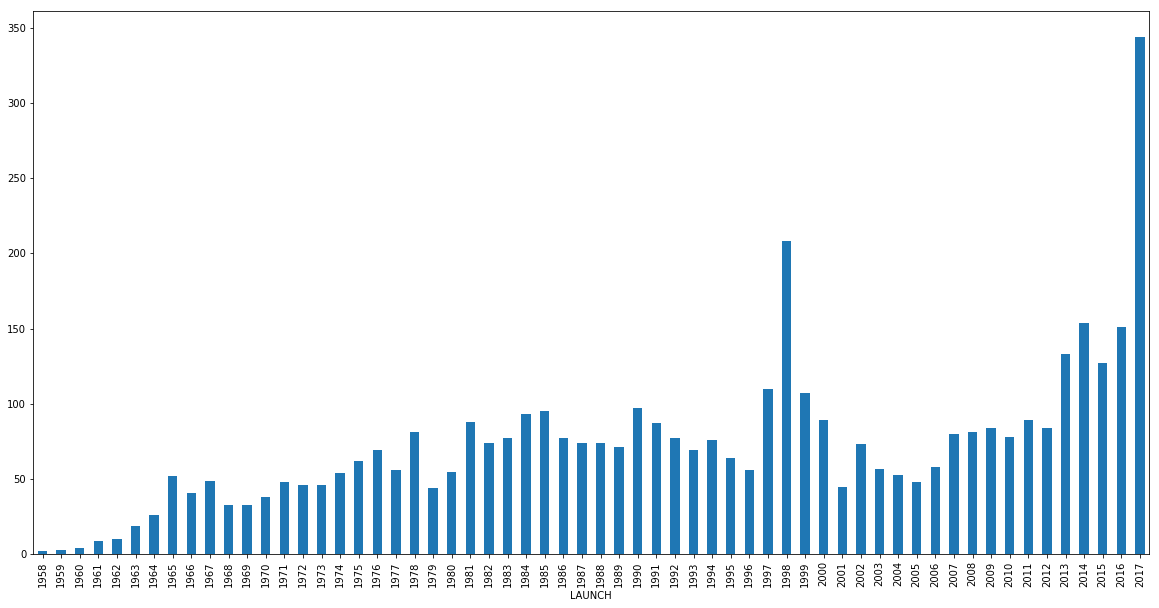

In [14]:
sioi["LAUNCH"]= pd.to_datetime(sioi["LAUNCH"]).apply(lambda x: x.strftime('%Y'))
sioi.groupby("LAUNCH").size().plot(kind="bar", figsize=(20,10))
plt.show()

There is clearly an increasing tendency throughout the years. The exponential behaviour in the latest year could be explained by the democratization of cube satellites lauch for commercial use.

### Satellites Statistics per Country

The last file contains various statistics per country.

In [15]:
sspc = pd.read_csv("Dataset/sat_statistics_per_country.csv")
sspc.head()

COUNTRY SPADOC_CD  ORBITAL_TBA  \
0  ARAB SATELLITE COMMUNICATIONS ORGANIZATION        AB            0   
1                                ASIASAT CORP        AC            0   
2                                     ALGERIA       ALG            0   
3                                   ARGENTINA      ARGN            0   
4                                     AUSTRIA      ASRA            0   

   ORBITAL_PAYLOAD_COUNT  ORBITAL_ROCKET_BODY_COUNT  ORBITAL_DEBRIS_COUNT  \
0                     13                          0                     0   
1                      8                          0                     0   
2                      5                          0                     0   
3                     17                          0                     0   
4                      3                          0                     0   

   ORBITAL_TOTAL_COUNT  DECAYED_PAYLOAD_COUNT  DECAYED_ROCKET_BODY_COUNT  \
0                   13                      1                          0   
1                    8                      0                          0   
2                    5                      0                          0   
3                   17                      2                          0   
4                    3                      0                          0   

   DECAYED_DEBRIS_COUNT  DECAYED_TOTAL_COUNT  COUNTRY_TOTAL  
0                     0                    1             14  
1                     0                    0              8  
2                     0                    0              5  
3                     0                    2             19  
4                     0                    0              3

This file will not be used in the exploitation part. However, for the sake of curiosity, we can still plot the distribution of satellites per country.

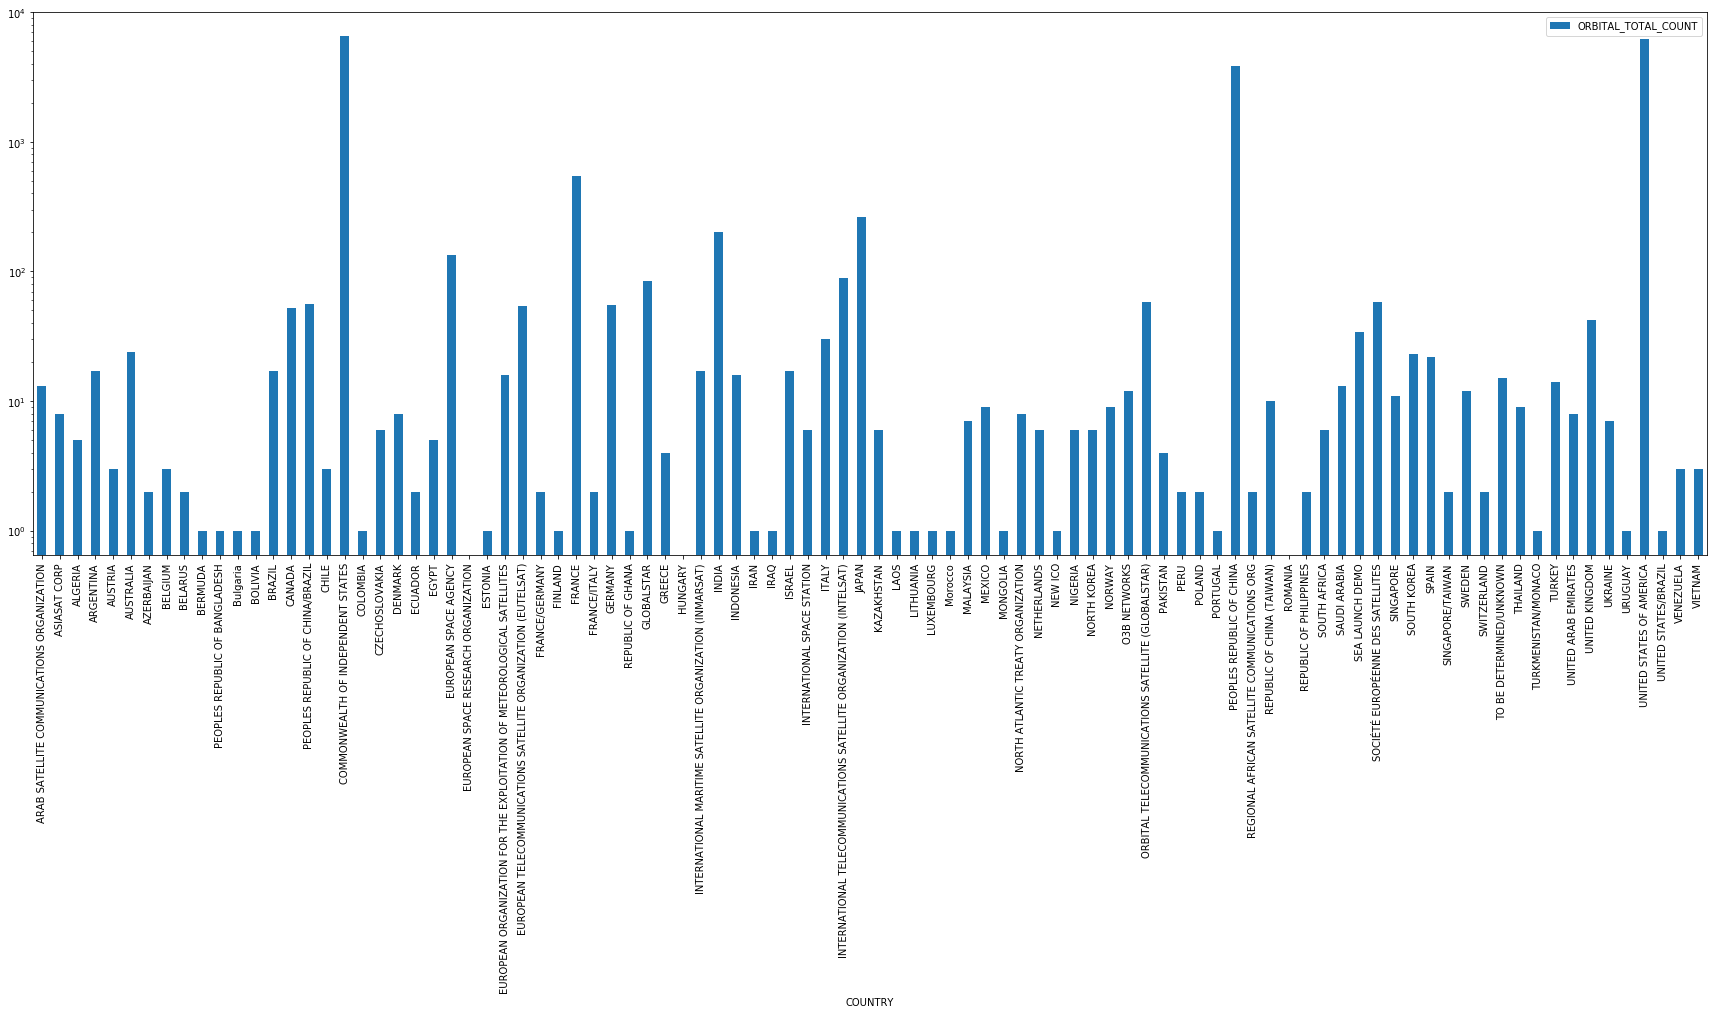

In [16]:
sspc = sspc[["COUNTRY", "ORBITAL_TOTAL_COUNT"]].set_index("COUNTRY")
sspc = sspc.drop("ALL")
sspc.plot(kind='bar', figsize = (30, 10), logy=True)
plt.show()

Not suprisingly the most active countries are the USA, China and Russia (more precisely Commonwealth of independant states)

## Data Exploitation

We will combine the first two files from the exploratory part, namely the TLE file and the "Satellites in Orbit Info" file. As we saw before they don't contain the same data. In order to use data present on both file we will merge both dataframe on their "Object_Name"

In [17]:
#mask = (data_m['Elevation [km]'].astype('float64') < 50000)
#data_final = data_m[mask]
data_m = pd.merge(no_deb,sioi,how='inner', on="OBJECT_NAME")
data_m.head()

OBJECT_NAME        Longitude [°]         Latitude [°] Elevation [km]  \
0    VANGUARD 1   -63.01315328238157   -26.65173623575367    950.1053125   
1    VANGUARD 2   33.607191075144456   -32.25819456312109     2825.77825   
2  VANGUARD R/B   158.90670062542114   1.4622271746404283    746.4226875   
3    VANGUARD 3  -14.979412519707317  -30.811335100669776        3271.14   
4    EXPLORER 7    165.9903034740197    9.845133707399345   517.82565625   

   OBJECT_ID  NORAD_CAT_ID COUNTRY  PERIOD  INCLINATION  APOGEE  PERIGEE  \
0  1958-002B             5      US  132.75        34.24  3834.0    650.0   
1  1959-001A            11      US  121.47        32.87  2940.0    553.0   
2  1958-002A            16      US  137.32        34.28  4223.0    655.0   
3  1959-007A            20      US  124.62        33.35  3263.0    510.0   
4  1959-009A            22      US   96.36        50.28   683.0    486.0   

  LAUNCH  
0   1958  
1   1959  
2   1958  
3   1959  
4   1959

In [18]:
data_final = data_m # TODO (LAURIER): added because wouldn't compile otherwise
np.shape(data_final)

(4347, 12)

As one can observe, we had a rich amount of data. The goal of our first investigation was to find a way to group different satellite categories. To perform such a thing, we decided to cluster the satellites with respect to their orbit as the use of a Graph was a huge plus to perform this clustering. Moreover, we observed on [this](https://in-the-sky.org/satmap_worldmap.php) website that we should find a principal orbit oscillating around the equator which was a welcomed hint to be able to assess wheter our results are coherent.

In [19]:
dict_tle = {}
for i in range(0,len(lines_tot)-1,3):
    dict_tle[lines_tot[i][2:].strip('\n')] = (lines_tot[i+1],lines_tot[i+2])
    
keys = list(dict_tle.keys())
for i in keys:
    if i not in data_final['OBJECT_NAME'].values:
        del dict_tle[i]

As said before, we want to solve our problematic using a graph. To do so, we had to think about a metric to compare the different satellites. <br>
We decided to create a binary map for each satellites showing their trajectory during a single period. First, we sampled each satellite period by a fixed number of samples (in our case, we chose 200) and computed the satellites positions at each time sample using the [PyEphem](http://rhodesmill.org/pyephem/) library and the TLE file. The results were plotted on an array of size 180x360 where 180 and 360 represents the spread of the latitude and longitude respectively. <br>
Such a metric is similar to projecting the satellites' positions into a 2D plane representing the earth's surface. A single projection into a discrete point was too precise in our case and would make the comparison between the satellites impossible. To solve this problem, we projected the satellites positions into a square of fixed side length.

In [20]:
res = []
for i in (dict_tle.keys()):
    res.append(satellite_orbit(i,sioi,dict_tle))

In [21]:
orbit_grids = compute_grids(res)

Typical results of our mapping is shown on the next Figure. 

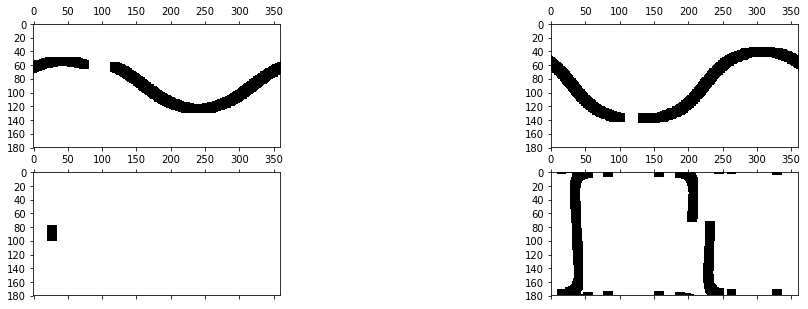

In [22]:
fig, axes = plt.subplots(2,2)
axes[0,0].spy(orbit_grids[0])
axes[0,1].spy(orbit_grids[5])
axes[1,0].spy(orbit_grids[200])
axes[1,1].spy(orbit_grids[150])

We could already observe from the first two plots that most of the satellites had a close trajectory with different phases. <br>
One can observe that a recurrent gap is present between the two tails of each plot. This is due to the approximation of the movement function computed by PyEphem and the period being supposedly not totally accurate. <br> 
The third plot is a typical example of the movement of a Geostationnary or Geosynchronous satellite during one entire period. Indeed, as said before, a geostationnary satellite always cover the same area over time.<br>
The fourth image shows some flaws of our representation. Considering a fixed sampling rate and a squared representation of the earth's surface, the speed of the satellites are not constant in our referential. Hence, the sampled positions are not equidistant. Moreover, the lattitude 0° and 180° correspond to both poles. At these positions, variating the longitude does not make any sense as it remains the same point. In our 2D projection, this latter development appears as a discontinuities. <br>
Moreover, after a single period, some satellites undergo a large phase shift as can be seen on the fourth plot. This is the principal reason why we did not compute the trajectory of the satellites over more than one period. From one point, the satellite would have covered most of the map and this would falsify our results.

Let's have a look at all our satellites on a world map.

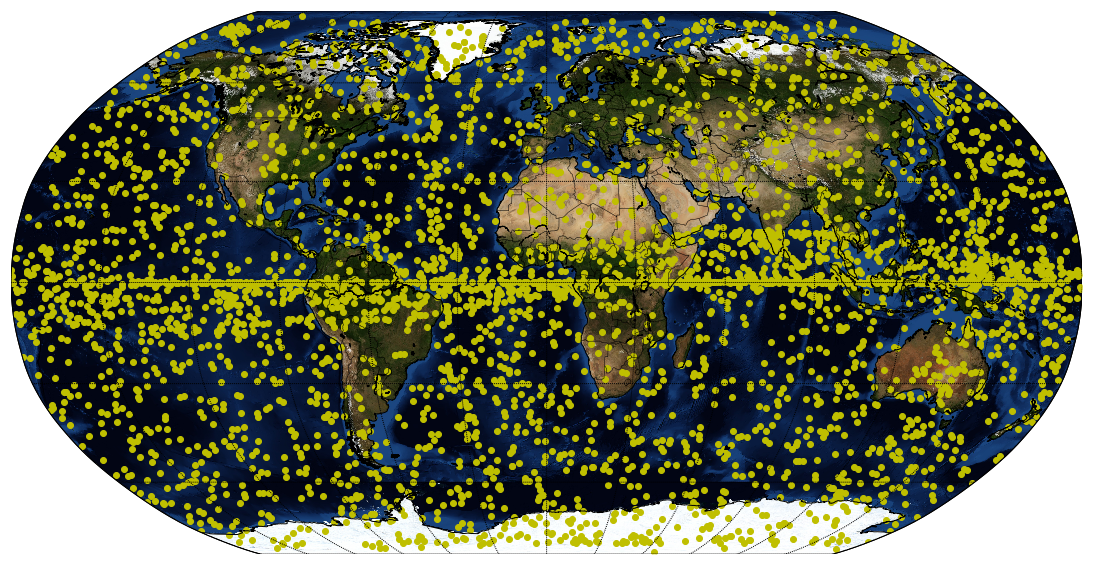

In [23]:
plot_map(data_final)

Without any processing, satellites are covering most of the globe. Hence this raw data cannot be used to process some analysis. <br>
However, The latter plot already illustrates some of the different clusters we want to highlight. The most remarkable is the geostationnary cluster being the dense line along the equator. One pattern moving down the Atlantic sea and reaching up over Australia and the Philippines sea can also be noticed.

Now we had to define a metric to compare our different grid maps. To do so, we decided to apply a logical "and" between the binary maps and taking the sum of the resulting matrix to define the weight between two satellites. This would give a high coefficient for satellites having the same trajectory. A high coefficient is directly proportional to a high weight, hence we did not have use another mathematical tool such as a decreasing exponential to make small coefficients become a high weight.

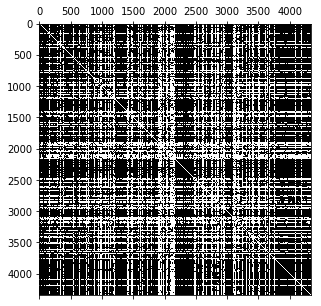

In [24]:
adja = compute_adja(orbit_grids)
plt.spy(adja)

The resulting blank lines are probably from the geostationnary satellites having only a small amount of pixels in common with other trajectories. <br>
The next step is to filter the satellites having a small amount of pixels in common. To do such a thing, we applied a simple threshold.

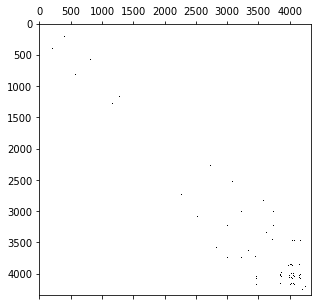

In [25]:
threshold = 8000
final = adja*(adja>threshold)
plt.spy(final)

The resulting matrix is really sparse. For such a huge matrix (4347x4347) it was necessary to sparsify it to be able to perform a coherent clustering without too much noise.

Let's have a look at the graph with the [PyGSP](https://github.com/epfl-lts2/pygsp) library.

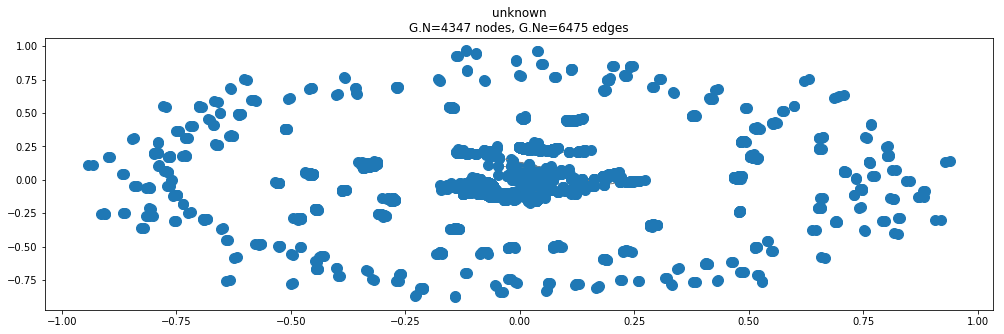

In [26]:
G = graphs.Graph(final)
G.set_coordinates('spring')
G.plot()

The spring coordinates allowed us to identify a central pattern. Let's apply a DBSCAN algorithm to the latter coordinates to isolate this central pattern

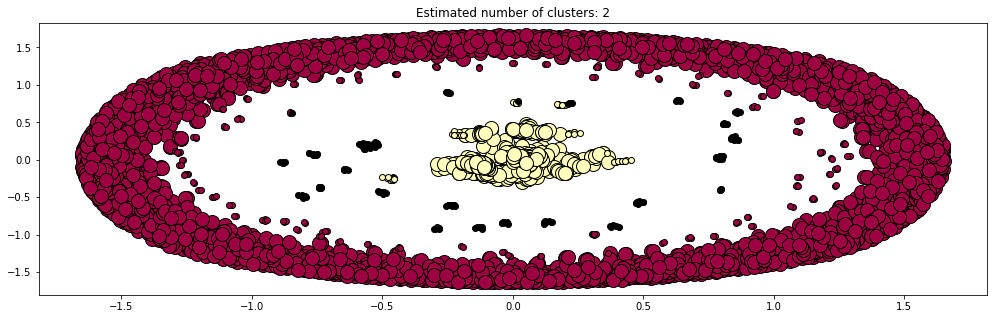

In [27]:
labels1 = dbscan_func(G,0.3,100)

In order to assess which color corresponds to which label, we plot the graph using the labels vector as a signal.

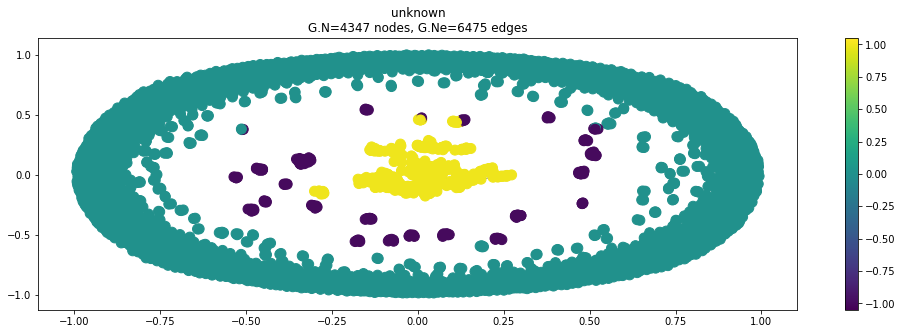

In [28]:
G.plot_signal(labels1)

We are interested in the points having the label 1. Let's plot the respective sattellites on a world map.

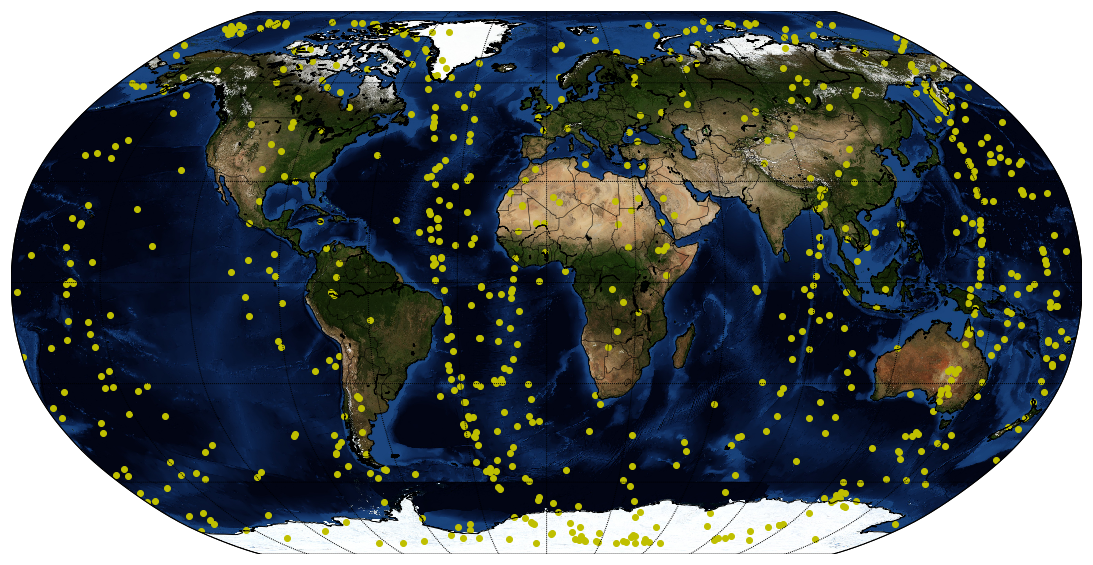

In [29]:
plot_map(data_final,labels1,1)

We can observe that this central pattern really had a meaning with respect to our goal. The plotted satellites have the same orbit with different phase shifts. 
The next step is to cluster these different phases. To do so, let's process another DBSCAN on these satellites.

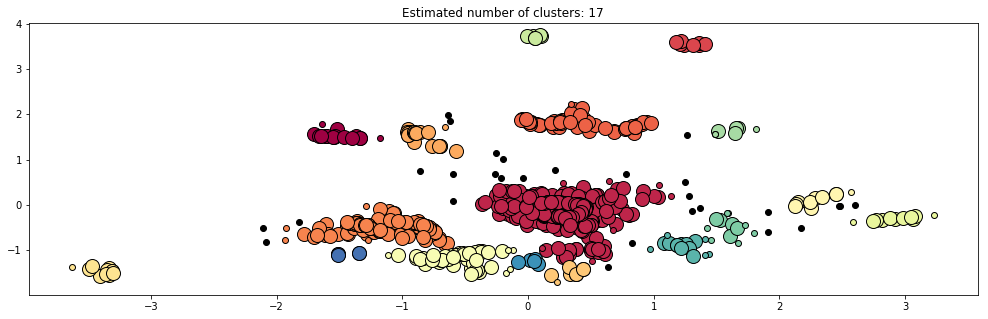

In [30]:
labels2 = dbscan_func(G,0.2,5,labels1,1)

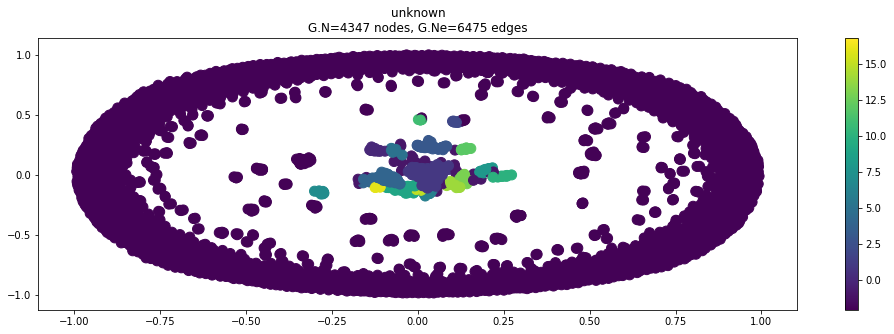

In [31]:
indices = np.where(labels1==1)
labels3 = np.ones(len(labels1))*(-2)
labels3[[indices]] = labels2
G.plot_signal(labels3)

This latter processing allowed us to cluster the trajectories with respect to their phase shift. The plot illustrated below shows the pricipal trajectory that we already observed in the first world map plot. The previous processing allowed us to isolate it in a single cluster. 
Moreover the second plot confirms that the clustering has been done with respect to their phase shift. <br>
There are some noise on the first plot. To avoid having noise, we could have simply be more strict during the second dbscan. However, this would result in having a lot of outliers, which is not optimal.

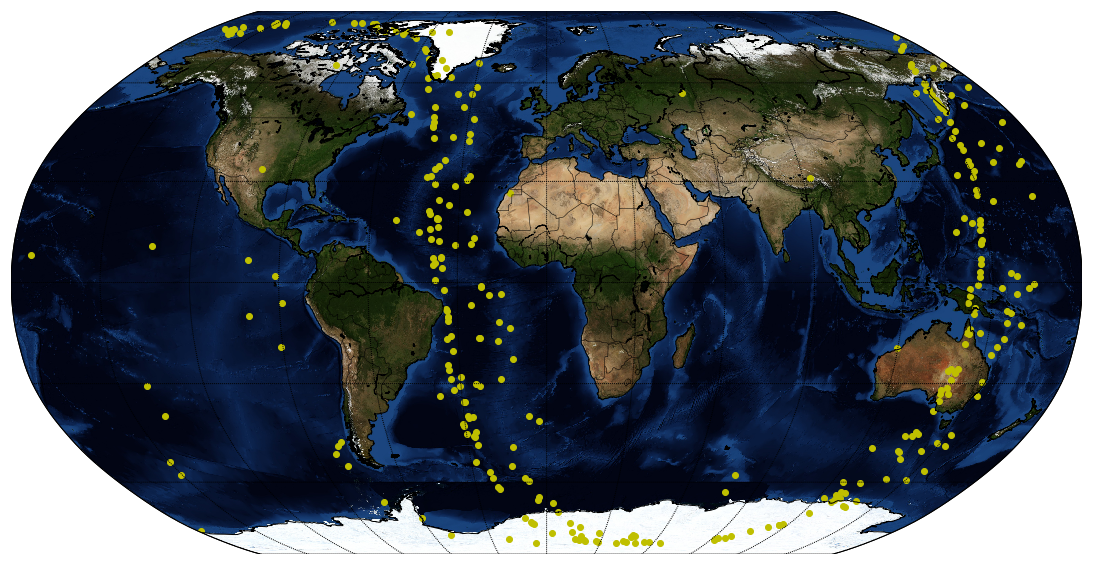

In [32]:
plot_map(data_final,labels3,1)

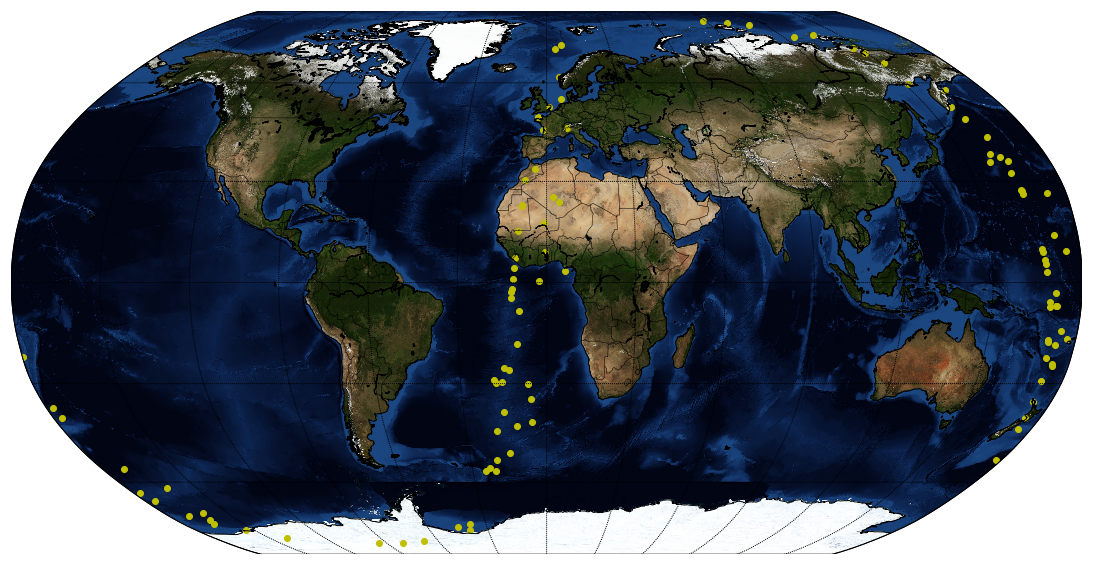

In [33]:
plot_map(data_final,labels3,4)

As said before, the geostationnary satellites always cover the same area of the earth's surface over time. That's why, considering our metric, we cannot cluster them. <br>
However, there is a simpler way without using any graph to observe them. As their area of observed surface is really small, we can perform a threshold directly on the metric's coefficients. This will isolate the satellites covering small areas. As all the other satellites oscillates, they're area must be bigger that the geostationary's.

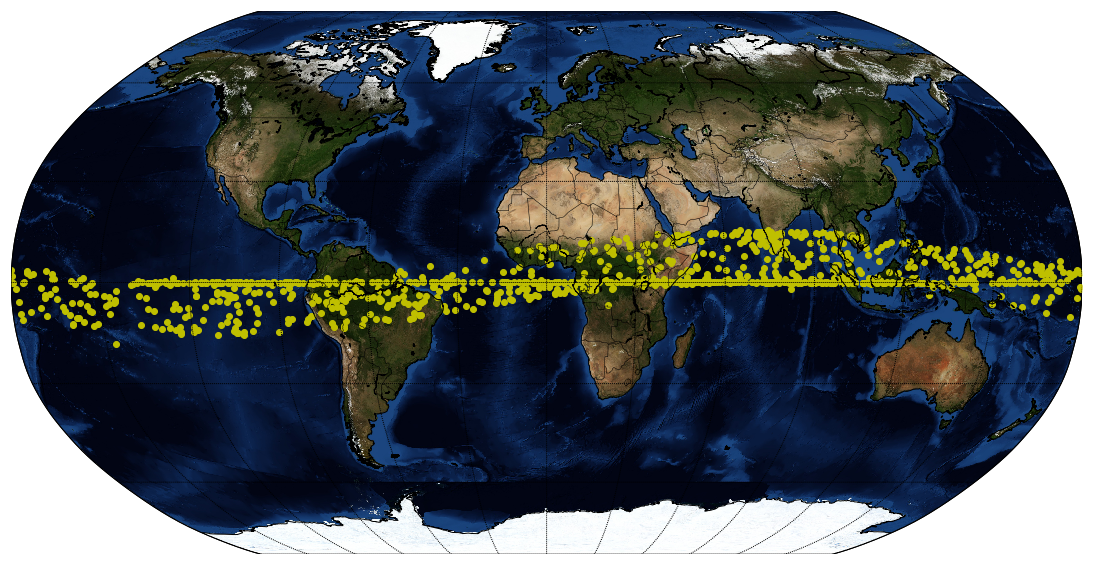

In [34]:
summ = np.zeros([len(orbit_grids),1])
for n,i in enumerate(orbit_grids):
    summ[n] = np.sum(i)
summ = summ*(summ<1000)
mask = summ>0
mask = (mask==True).T[0]
plot_map(data_final,mask.T,True)

The simple threshold worked without any noise. We were able to highlight the geostationnary satellites without the use of any graph processing. <br>
The precise constant line over the equator corresponds to the Geostationnary satellites. However, the other trajectory oscillating with a very small amplitude is called the Geosynchronous orbit. These respective satellites are at the same height of the Geostationnary satellites, but with a small angle, resulting in a small vertical oscillation. <br>
To be able to separate these two orbits, one could simply make the threshold more or less relaxed.

# SATCAT launch site analysis 

In this analysis, we will attempt to identify from which launch site a satellite has been launched from informations provided by the [SATCAT database](https://celestrak.com/satcat/search.asp), such as its orbital parameters, country of origin, nature, etc.

The goal will be to identify satellites launch site by using only a subset of labeled satellites.
We want to see what type of precision we can obtain with graph-based analysis.

This analysis provide an other angle of approach to the previous orbit analysis. 
Before, we tried to match satellites regarding their orbit.
Now, the goal is to link satellites to where they launched using not only the orbit data, but other discrete informations.
 
** Note: ** Various helper functions have been used for this section. They can be found [here](helpers_satcat.py).


## SATCAT data extraction

To have a cleaner notebook, we extracted the data from the SATCAT dataset using an [external script](./create_satcat_json.py).

This script generates a json file containing the formatted SATCAT data and more complete information on the files.

### Extract celestrack SATCAT data

In [35]:
with open("Dataset/satcat_info.json") as f:
    satcat_info_json = json.load(f)

In [36]:
# Extract the main dataset and put it in a dataframe
sat_info_array = satcat_info_json["sat_data"]
satcat_df = pd.DataFrame(sat_info_array)
satcat_df = satcat_df.set_index("NORAD")
display(satcat_df.head(5))

apogee  decay_date  inclination launch_date  launch_nbr launch_piece  \
NORAD                                                                         
1       938.0  1957-12-01         65.1  1957-10-04           1          A     
2       945.0  1958-01-03         65.0  1957-10-04           1          B     
3      1659.0  1958-04-14         65.3  1957-11-03           2          A     
4       215.0  1970-03-31         33.2  1958-02-01           1          A     
5      3834.0                     34.3  1958-03-17           2          B     

      launch_site  launch_year  multiple_name_flag        name  \
NORAD                                                            
1           TYMSC         1957               False    SL-1 R/B   
2           TYMSC         1957               False   SPUTNIK 1   
3           TYMSC         1957               False   SPUTNIK 2   
4           AFETR         1958               False  EXPLORER 1   
5           AFETR         1958               False  VANGUARD 1   

      operational_status  orbital_period orbital_status  payload_flag  \
NORAD                                                                   
1                Decayed            96.2             EA         False   
2                Decayed            96.1             EA          True   
3                Decayed           103.7             EA          True   
4                Decayed            88.5             EA          True   
5                Unknown           132.8             EA          True   

       perigee  radar_cross_section source  
NORAD                                       
1        214.0               20.420    CIS  
2        227.0                  NaN    CIS  
3        211.0                0.080    CIS  
4        183.0                  NaN     US  
5        650.0                0.122     US

In [37]:
# Extract complementary information dictionary
operational_status_dict = satcat_info_json["operational_status"]
launch_site_full_name_dict = satcat_info_json["launch_site"]
source_full_name_dict = satcat_info_json["source"]

Fill NaN in satcat data

In [38]:
satcat_df = satcat_df.fillna(value=0)

## Data Exploration

In this section, we want to see how the different parameters of the satellites are distributed.

To do so, we will analyze the various parameters.
We used a systematic approach, where for each parameter of interest, we did a short analysis

### Launch site 

In [39]:
# Create dict to transform launch site to numerical value
num_launch_site_dict = {}
for index,site in enumerate(satcat_df.launch_site.unique()):
    num_launch_site_dict[site] = index

In [40]:
num_launch_site = satcat_df.launch_site.map(lambda x:num_launch_site_dict[x])
num_launch_site.name = "num_launch_site"
satcat_df = pd.concat([satcat_df,num_launch_site], axis=1)

In [41]:
# How many launch of payloads (functionning satellites) per site
launches_per_site = satcat_df.loc[satcat_df.payload_flag == True].launch_site.value_counts()
display(launches_per_site.head(5))

PLMSC    2088
TYMSC    1882
AFETR     892
AFWTR     851
FRGUI     472
Name: launch_site, dtype: int64

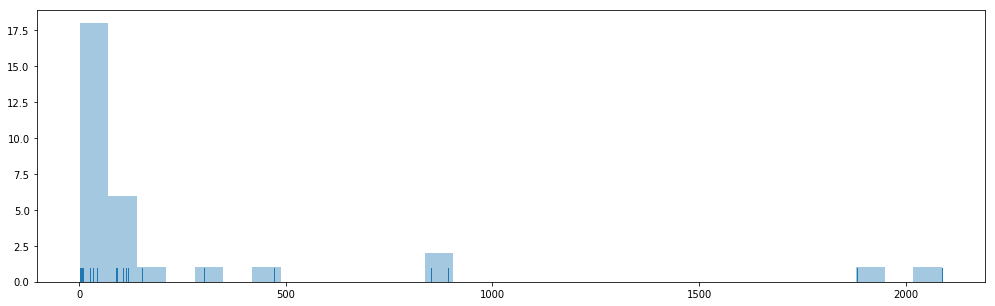

In [42]:
sns.distplot(launches_per_site.values,kde=False, rug=True)
plt.show()

We can see from this figure that there's many small launch sites, but very few larger one.
To do data analysis, we want relatively big datasets, sot this encourages us to analyse bigger launch sites.

In the end, we chose to analyse the larger United States aunch sites, but a similar analysis could be done for the Russian (USSR historically) launch sites

In [43]:
bigger_launch_sites = ["TYMSC", "PLMSC"]
print("Russian launch sites:")
for index in range(2):
    print("\t{}) {} ({})".format(index+1, launch_site_full_name_dict[bigger_launch_sites[index]], bigger_launch_sites[index]))


Russian launch sites:
	1) Tyuratam Missile and Space Center, Kazakhstan (Also known as Baikonur Cosmodrome) (TYMSC)
	2) Plesetsk Missile and Space Complex, Russia (PLMSC)


On another note, one might think that the discrepancy in the number of 
launch means that the Russian's launched more satellites than the United States.
In fact, this difference could be caused by the [USA Classified Satellites](https://en.wikipedia.org/wiki/List_of_NRO_launches)
which didn't make it into the list.

### Country of origin

In [44]:
# Create dict to transform launch site to numerical value
num_source_dict = {}
for index,site in enumerate(satcat_df.source.unique()):
    num_source_dict[site] = index

In [45]:
# How many launch per sources
launches_per_source = satcat_df.source.value_counts()
display(launches_per_source.head(5))

CIS    21491
US     11387
PRC     5192
FR      1263
IND      536
Name: source, dtype: int64

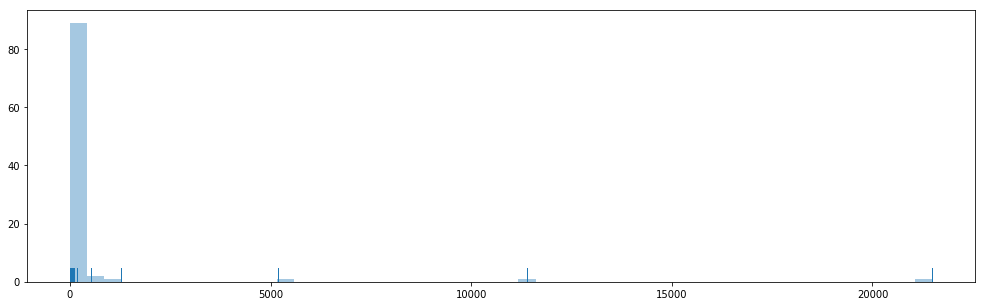

In [46]:
sns.distplot(launches_per_source.values,kde=False, rug=True)
plt.show()

### Operational Status

In [47]:
num_operational_status_dict = {}
for index, status in enumerate(satcat_df.operational_status.unique()):
    num_operational_status_dict[status] = index
print(num_operational_status_dict)

{'Decayed': 0, 'Unknown': 1, 'Nonoperational': 2, 'Operational': 3, 'Partially Operational': 4, 'Backup/Standby': 5, 'Spare': 6, 'Extended Mission': 7}


In [48]:
# How many satellites per operational status
operational_status_count = satcat_df.operational_status.value_counts()
display(operational_status_count)

Decayed                  23970
Unknown                  15041
Operational               1754
Nonoperational            1070
Partially Operational       53
Backup/Standby              17
Spare                        2
Extended Mission             2
Name: operational_status, dtype: int64

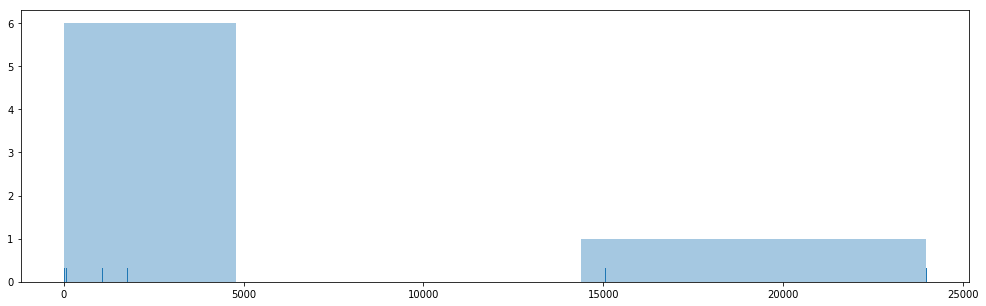

In [49]:
sns.distplot(operational_status_count.values,kde=False, rug=True)
plt.show()

Most satellites decay over time, and there's actually not that many active ones.
Studying only active ones might be to limiting, so we will include historic satellites in our analysis.

### Orbital status

See: [Orbital Status Code](https://celestrak.com/satcat/satcat-format.asp) for the meaning of the code

In [50]:
orbital_statuses = satcat_df.orbital_status.unique()
print(len(orbital_statuses), "\n", orbital_statuses)

8 
 ['EA' 'NEA' 'EA2' 'MO2' 'MA0' 'EL0' 'DOC' 'ISS']


In [51]:
num_orbital_status_dict = {}
for index, status in enumerate(orbital_statuses):
    num_orbital_status_dict[status] = index
print(num_orbital_status_dict)

{'EA': 0, 'NEA': 1, 'EA2': 2, 'MO2': 3, 'MA0': 4, 'EL0': 5, 'DOC': 6, 'ISS': 7}


In [52]:
# How many satellites per orbital status
orbital_status_count = satcat_df.orbital_status.value_counts()
display(orbital_status_count)

EA     41832
NEA       68
ISS        4
DOC        1
MA0        1
EA2        1
MO2        1
EL0        1
Name: orbital_status, dtype: int64

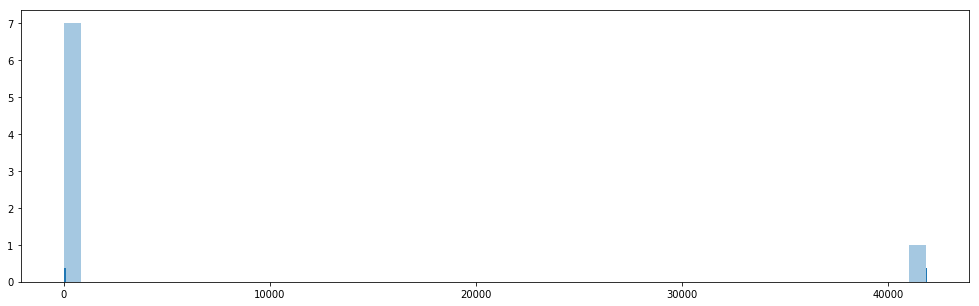

In [53]:
sns.distplot(orbital_status_count.values,kde=False, rug=True)
plt.show()

Almost all satelites are "EA", which means that they are in earth orbits.
Because of this, orbital status have limited interest for our analysis.

### Orbital Parameters

For each [orbital parameters](https://en.wikipedia.org/wiki/Orbital_elements) we want to do a distribution analysis by launch site

In [54]:
ORBITAL_PARAMETERS_COLS = ["apogee", "inclination", "launch_year", "orbital_period", "perigee"] 

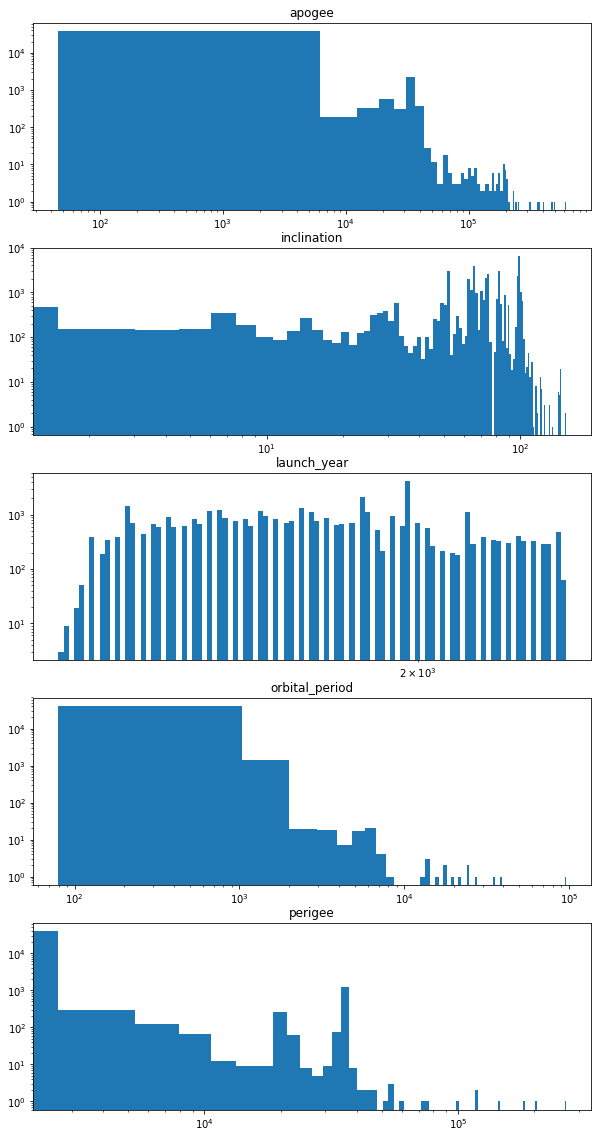

In [55]:
fig, axes = plt.subplots(len(ORBITAL_PARAMETERS_COLS), 1, figsize=(10,20))

for index, parameter in enumerate(ORBITAL_PARAMETERS_COLS):
    axes[index].hist(satcat_df[parameter].values, bins=100);
    axes[index].set_xscale("log")
    axes[index].set_yscale("log")
    axes[index].set_title(parameter)
plt.show()

We can see that there's a vast distribution for each orbital parameters. 
Because we have limited astrophisics knoweldge, it would be hard to differenciate those parameters manually.

The next sections will attempt to use those parameters, without using specific knoweldge on their meaning, to classify
the satellites.

## Data reduction 

To do clustering, we want to reduce the complexity of the target clusters. 

To do so, we will first reduce the number of launch sites and/or sources.

We chose to reduce the number of launch sites by selecting two of the launch sites with the most satellite launches.

Those are the main launch sites for the United States of America, the [Air Force Eastern Test Range, Florida, USA (AFETR)](https://en.wikipedia.org/wiki/Eastern_Range), which is linked to the [Cape Canaveral Air Force Station](https://en.wikipedia.org/wiki/Cape_Canaveral_Air_Force_Station) and the [Kennedy Space Center](https://en.wikipedia.org/wiki/Kennedy_Space_Center), and the [Air Force Western Test Range, California, USA (AFWTR)](https://en.wikipedia.org/wiki/Western_Range), which is linked to the [Vandenberg Air Force Base](https://en.wikipedia.org/wiki/Vandenberg_Air_Force_Base).

We used those specific launch sites because they are the 3rd and 4th largest in term of satellite sent and they have very simmilar numbers of satellite sent (AFETR: 892, AFWTR: 851)
In addition, because they are located at either part of the same country, there's a good chance that they were used for different purposes.
Because difference between the launch-sites's satellites is key in our analysis, this is a key reason for which we got good results.

** Note: ** In addition, we created function to reduce the number of launch sites by using their relative importance. The interested user can look into the function "data_reduction_per_percentile" for more information.

In [56]:
LAUNCH_SITES = ["AFETR", "AFWTR"]

In [57]:
reduced_satcat_df = data_reduction_per_launch_site(satcat_df, LAUNCH_SITES)

In [58]:
print(reduced_satcat_df.source.unique())
display(reduced_satcat_df.head(5))

['US' 'UK' 'ITSO' 'ESRO' 'NATO' 'CA' 'FGER' 'INDO' 'ESA' 'JPN' 'IT' 'IND'
 'ARGN' 'GER' 'AB' 'MEX' 'AUS' 'RP' 'SWED' 'NOR' 'IM' 'EUTE' 'NETH' 'GREC'
 'BRAZ' 'SES' 'SKOR' 'ABS' 'PAKI' 'GLOB' 'CIS' 'ROC' 'SPN' 'NICO' 'AC'
 'ORB' 'THAI' 'TMMC' 'BUL' 'FR' 'DEN' 'SAFR']


apogee  decay_date  inclination launch_date  launch_nbr launch_piece  \
NORAD                                                                         
4       215.0  1970-03-31         33.2  1958-02-01           1          A     
5      3834.0                     34.3  1958-03-17           2          B     
6      1739.0  1958-06-28         33.5  1958-03-26           3          A     
9       585.0  1959-10-23         50.3  1958-07-26           5          A     
10     1187.0  1959-01-21         32.3  1958-12-18           6          A     

      launch_site  launch_year  multiple_name_flag        name  \
NORAD                                                            
4           AFETR         1958               False  EXPLORER 1   
5           AFETR         1958               False  VANGUARD 1   
6           AFETR         1958               False  EXPLORER 3   
9           AFETR         1958               False  EXPLORER 4   
10          AFETR         1958               False       SCORE   

      operational_status  orbital_period orbital_status  payload_flag  \
NORAD                                                                   
4                Decayed            88.5             EA          True   
5                Unknown           132.8             EA          True   
6                Decayed           103.6             EA          True   
9                Decayed            92.8             EA          True   
10               Decayed            98.2             EA          True   

       perigee  radar_cross_section source  num_launch_site  
NORAD                                                        
4        183.0                0.000     US                1  
5        650.0                0.122     US                1  
6        117.0                0.000     US                1  
9        239.0                0.000     US                1  
10       159.0                0.000     US                1

We can see that many countries/groups used those launch sites. 
This is good, because they likely used them selectively for their specific launch properties.
Because of this, we will keep the various sources in the dataset

### Reduce by payload or operational

To reduce even more the size of the dataset, we can chose to keep only payloads and/or operational satellites in the dataset.

We chose to keep only payloads, because the dataset has many other types, such as debris and launchers, which are not really interesting for our analysis.

We chose to use all historic satellites to have more data on which to work.
Indeed, we showed above that there's relatively few satellites remaining in orbit compared to the amount that where launched historically.
Also historic satellites are likely to follow similar orbits as modern satellites.

In [59]:
ONLY_PAYLOAD=True
ONLY_OPERATIONAL=False
print("Length before further reduction: ", len(reduced_satcat_df))
if ONLY_PAYLOAD:
    reduced_satcat_df = reduced_satcat_df.loc[reduced_satcat_df.payload_flag == True]
if ONLY_OPERATIONAL:
    reduced_satcat_df = reduced_satcat_df.loc[reduced_satcat_df.operational_status == "Operational"]
    
print("Length after reduction: ", len(reduced_satcat_df))

Length before further reduction:  10253
Length after reduction:  1743


In [60]:
# We can now delete satcat_df, it will not be needed again
del satcat_df

## Extract Features and Labels

### Create Features DataFrame

We now want to extract the features for each satellite. 
As a first glance, we want to keep as much data as possible. Later on we might drop some features.

In [61]:
display(reduced_satcat_df.head(5))

apogee  decay_date  inclination launch_date  launch_nbr launch_piece  \
NORAD                                                                         
4       215.0  1970-03-31         33.2  1958-02-01           1          A     
5      3834.0                     34.3  1958-03-17           2          B     
6      1739.0  1958-06-28         33.5  1958-03-26           3          A     
9       585.0  1959-10-23         50.3  1958-07-26           5          A     
10     1187.0  1959-01-21         32.3  1958-12-18           6          A     

      launch_site  launch_year  multiple_name_flag        name  \
NORAD                                                            
4           AFETR         1958               False  EXPLORER 1   
5           AFETR         1958               False  VANGUARD 1   
6           AFETR         1958               False  EXPLORER 3   
9           AFETR         1958               False  EXPLORER 4   
10          AFETR         1958               False       SCORE   

      operational_status  orbital_period orbital_status  payload_flag  \
NORAD                                                                   
4                Decayed            88.5             EA          True   
5                Unknown           132.8             EA          True   
6                Decayed           103.6             EA          True   
9                Decayed            92.8             EA          True   
10               Decayed            98.2             EA          True   

       perigee  radar_cross_section source  num_launch_site  
NORAD                                                        
4        183.0                0.000     US                1  
5        650.0                0.122     US                1  
6        117.0                0.000     US                1  
9        239.0                0.000     US                1  
10       159.0                0.000     US                1

In [62]:
display(reduced_satcat_df.orbital_status.unique())

array(['EA', 'NEA', 'EA2', 'ISS'], dtype=object)

In [63]:
# Note: because this function is key to understanding how we create the features, we kept it in the notebook

def get_feature_dataframe(reduced_satcat_df, only_payload=True, only_operational=False):
    """Function to create the feature dataframe"""
    # We keep all the features that could have an impact on the clustering
    # Note: We do this in a general fashion, so we keep features that could have been reduced just in case

    # Numeric Features : "apogee", "inclination", "launch_year", "orbital_period", "perigee", "radar_cross_section"
    # Boolean Features : "payload_flag"
    # List Features    : "operational_status", "orbital_status", "source"
    numeric_features = ["apogee", "inclination", "launch_year", "orbital_period", "perigee", "radar_cross_section"]
    boolean_features = ["payload_flag"]
    list_features = ["operational_status", "orbital_status", "source"]
    features_columns = numeric_features + boolean_features + list_features

    # Numeric features don't require special management
    features_df = reduced_satcat_df[numeric_features]
    display(features_df.head(5))

    # Transform boolean features to numeric
    num_payload_flag = reduced_satcat_df.payload_flag.map (\
                                lambda x : 1 if x else 0
                       )
    if not only_payload:
        features_df = features_df.assign(payload_flag = num_payload_flag)

    # We need to transform the List features in a numerical form, we will use the unique value index to do so
    # We previously created indexes to be able to find them easily
    # "operational_status" : num_operational_status_dict
    # "orbital_status" : num_orbital_status_dict
    # "source": num_source_dict
    num_operational_status = reduced_satcat_df.operational_status.map( \
                                    lambda x : num_operational_status_dict[x] \
                             )
    num_orbital_status = reduced_satcat_df.orbital_status.map( \
                                    lambda x : num_orbital_status_dict[x] \
                             )
    num_source = reduced_satcat_df.source.map( \
                                    lambda x : num_source_dict[x] \
                             )
    if not only_operational:
        features_df = features_df.assign(operational_status = num_operational_status)
    # We could use orbital status, but as we have seen above, it provides very little 
    # information because most of the statuses are the same
    #features_df = features_df.assign(orbital_status = num_orbital_status)
    features_df = features_df.assign(source = num_source)
    
    return features_df

In [64]:
features_df = get_feature_dataframe(reduced_satcat_df, ONLY_PAYLOAD, ONLY_OPERATIONAL)
display(features_df.head(5))

apogee  inclination  launch_year  orbital_period  perigee  \
NORAD                                                              
4       215.0         33.2         1958            88.5    183.0   
5      3834.0         34.3         1958           132.8    650.0   
6      1739.0         33.5         1958           103.6    117.0   
9       585.0         50.3         1958            92.8    239.0   
10     1187.0         32.3         1958            98.2    159.0   

       radar_cross_section  
NORAD                       
4                    0.000  
5                    0.122  
6                    0.000  
9                    0.000  
10                   0.000

apogee  inclination  launch_year  orbital_period  perigee  \
NORAD                                                              
4       215.0         33.2         1958            88.5    183.0   
5      3834.0         34.3         1958           132.8    650.0   
6      1739.0         33.5         1958           103.6    117.0   
9       585.0         50.3         1958            92.8    239.0   
10     1187.0         32.3         1958            98.2    159.0   

       radar_cross_section  operational_status  source  
NORAD                                                   
4                    0.000                   0       1  
5                    0.122                   1       1  
6                    0.000                   0       1  
9                    0.000                   0       1  
10                   0.000                   0       1

### Normalize features

We want to normalize the features so they have equivalent weight in the rest of our analysis

In [65]:
features_df = normalize_features(features_df)
display(features_df.head(5))

apogee  inclination  launch_year  orbital_period   perigee  \
NORAD                                                                 
4     -0.390693    -0.766486     -1.44112       -0.192732 -0.501090   
5     -0.285957    -0.734247     -1.44112       -0.176636 -0.473941   
6     -0.346588    -0.757693     -1.44112       -0.187246 -0.504927   
9     -0.379985    -0.265311     -1.44112       -0.191170 -0.497834   
10    -0.362563    -0.792864     -1.44112       -0.189208 -0.502485   

       radar_cross_section  operational_status    source  
NORAD                                                     
4                -0.171139           -0.943187 -0.312776  
5                -0.168288           -0.147073 -0.312776  
6                -0.171139           -0.943187 -0.312776  
9                -0.171139           -0.943187 -0.312776  
10               -0.171139           -0.943187 -0.312776

### Create Labels 

In [66]:
num_launch_site = reduced_satcat_df.num_launch_site
label_df = pd.DataFrame(num_launch_site)
display(label_df.head(5))

num_launch_site
NORAD                 
4                    1
5                    1
6                    1
9                    1
10                   1

## Graph Analysis

### Weight matrix calculation

#### Distances

Using the features we calculate, we want to find the distance between the feature vectors.

We used the [braycurtis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.braycurtis.html) distance. Because it uses element wise difference of the feature vectors, it allows for comparison of parameters that are not numeric, such as the *list_features* above by giving each its relative importance. This is something that is not well achieved by euclidean distances for example.

In [67]:
distance_metric = "braycurtis"
distances = spatial.distance.squareform(spatial.distance.pdist(features_df, metric=distance_metric))

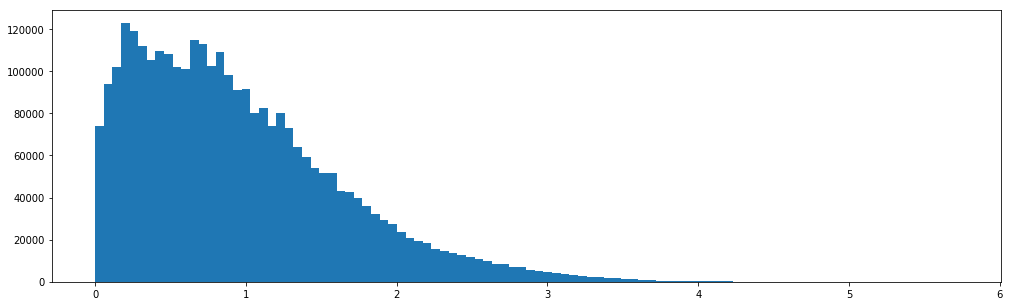

In [68]:
plt.hist(distances.reshape(-1), bins=100)
plt.show()

In [69]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))
print(len(distances))

2027 distances equal exactly zero.
1743


#### Weights

With the distances between the different features, we want to create a weight matrix that will
form the basis of our graph analysis

In [70]:
KERNEL_WIDTH_PERCENTILE = 0.5
weights = get_weights_from_distance(distances, KERNEL_WIDTH_PERCENTILE)
# Validate that all the weights on the diagonal are null
print(np.sum(np.diagonal(weights)==0))
print(len(weights))

1743
1743


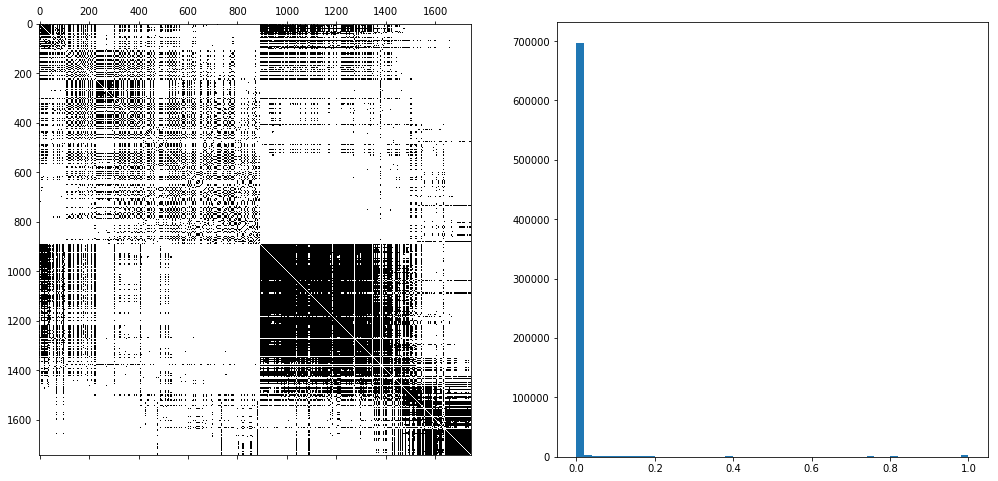

In [71]:
# Plot the resulting weight value
fix, axes = plt.subplots(1, 2, figsize=(17, 8))
plot_weight_hist(weights, axes[:], name="satcat_base_weight_hist")
plt.show()

#### Sparcify

We can see that most weights are very close to zero in the graph above.
We want to limit the connectiveness of graph and therefore we need to avoid 
edges that have very low values.

To reduce the connectiveness, we will select only the neighbors with the strongest connections.

Then, we will filter the remaining weights to remove those too close to zero, by replacing all weights that
are smaller than epsilon with the value 0.

100%|██████████| 1743/1743 [00:03<00:00, 493.46it/s]


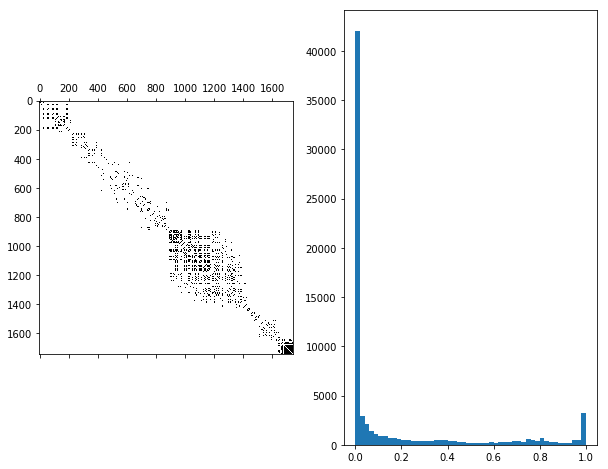

In [72]:
NEIGHBORS = 100
epsilon = 1e-8

weights = sparse_weights(weights, NEIGHBORS, epsilon)
fix, axes = plt.subplots(1, 2, figsize=(10, 8))
plot_weight_hist(weights, axes[:], name="satcat_sparse_weight_hist")

We can see that the resulting matrix is much more sparse than the previous one.
Also, we can clearly see clusters emerging in the dataset.

This is a good sign that graph analysis will be able to extract information from this weight matrix.

### Graph analysis 

To identify the clustering we seem to observe in the weight matrix, we will need to do more complete graph analysis.
We will use [networkx](https://networkx.github.io/) as the main tool for this step.

In [73]:
graph = create_graph_from_weights(weights, reduced_satcat_df)

We attributed to each node its NORAD id number, so we can track it even if the node numbering
changes, which will happen when we subdivise the graph in subgraphs

In [74]:
print(graph.node[0])

{'NORAD': 4}


#### Draw the network

Lets first overview the graph structure by visualizing it.
We colored the two different launch sites in the graph to help with analysis.

** Note: ** Altough the graph is colored, the actual algorithm has no idea of the colors in the graph.
            The coloring is simply aimed at helping with the analysis

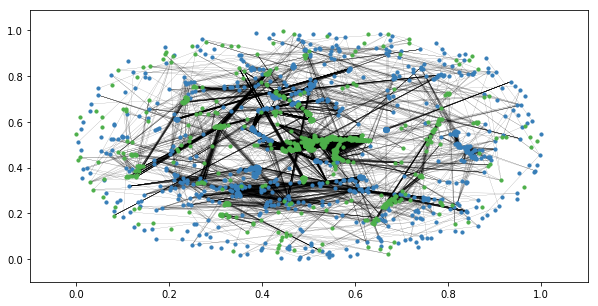

In [75]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
draw_graph(graph, axes, reduced_satcat_df, name="base_graph")
plt.show()

#### Filter the graph degree

We will first remove nodes with small amount of edges, because we can see that they don't really provide information on the clusters.

In the final analysis, we realized that it was better to only filter out "lonely nodes", i.e. nodes with no edges, because some node with only one edge are actually part of bigger clusters, so they have meaningfull information in them.

In [76]:
# Filter out lonely nodes
MINIMUM_DEGREE = 0 
print(len(graph.nodes()))
graph = remove_lonely_nodes(graph, minimum_degree = MINIMUM_DEGREE)
print(len(graph.nodes()))
# Do it again to remove resulting nodes with degree of 0
# Only if the minimum degree is greater than 0, otherwise 
# it would simply repeat the same thing
if MINIMUM_DEGREE > 0:
    graph = remove_lonely_nodes(graph, minimum_degree = 0)
print(len(graph.nodes()))

100%|██████████| 1743/1743 [00:00<00:00, 300937.38it/s]

1743
1631
1631


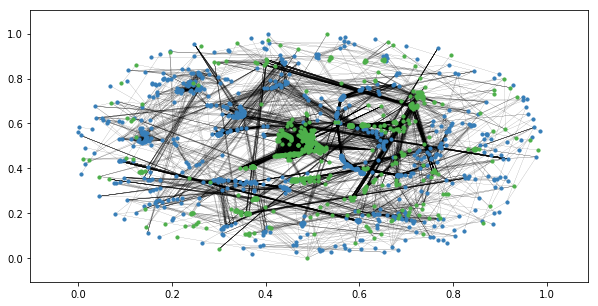

In [77]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
draw_graph(graph, axes, reduced_satcat_df, name="cleaned_base_graph")
plt.show()

We can see that there's clearly some major clusters appearing in the graph. 
The next step will be to attempt to segregate those clusters and extract see if we can identify they came from which launch site, and to which precision we can identify them.

##### Separate the graph into connected subgraphs

Altough the graph seems connected in the figures, the weight matrix above tells us another story.
There's clearly some subgraphs in there, even if we cannot see them.

In this step, we will separate the main unconnected graph into connected subgraphs.

In [78]:
connected_subgraphs = []
for subgraph in  nx.connected_component_subgraphs(graph):
    connected_subgraphs.append(nx.Graph(subgraph))
print(len(connected_subgraphs))

57


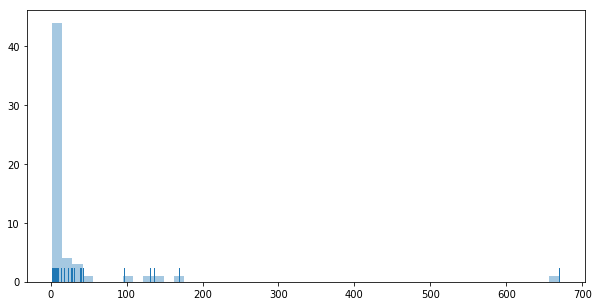

In [79]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))
print_subgraphs_nodes_dist(connected_subgraphs, axes)
plt.show()

We note that there's a lot of small graphs, without many nodes.

For the visual analysis, we will only use a subset of the graphs, otherwise there would be too many plots

We will keep those graph in the label analysis, this is why we save the smaller graph in the "small_subgraphs" variable.

In [80]:
nodes_nbr = get_nodes_nbr(connected_subgraphs)
MINIMUM_NBR_OF_NODES = np.percentile(nodes_nbr,
                                     90)
small_subgraphs = [connected_subgraphs[index] for index, val in enumerate(nodes_nbr) if val < MINIMUM_NBR_OF_NODES]
kept_subgraphs = [connected_subgraphs[index] for index, val in enumerate(nodes_nbr) if val >= MINIMUM_NBR_OF_NODES]
print(len(kept_subgraphs))

6


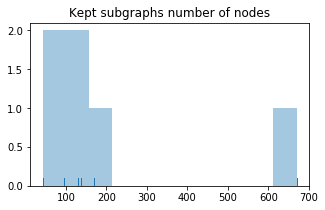

In [81]:
fig, axes = plt.subplots(1, 1, figsize=(5,3))
print_subgraphs_nodes_dist(kept_subgraphs, axes)
plt.title("Kept subgraphs number of nodes")
plt.show()

Lets visualize the bigger subgraphs we kept


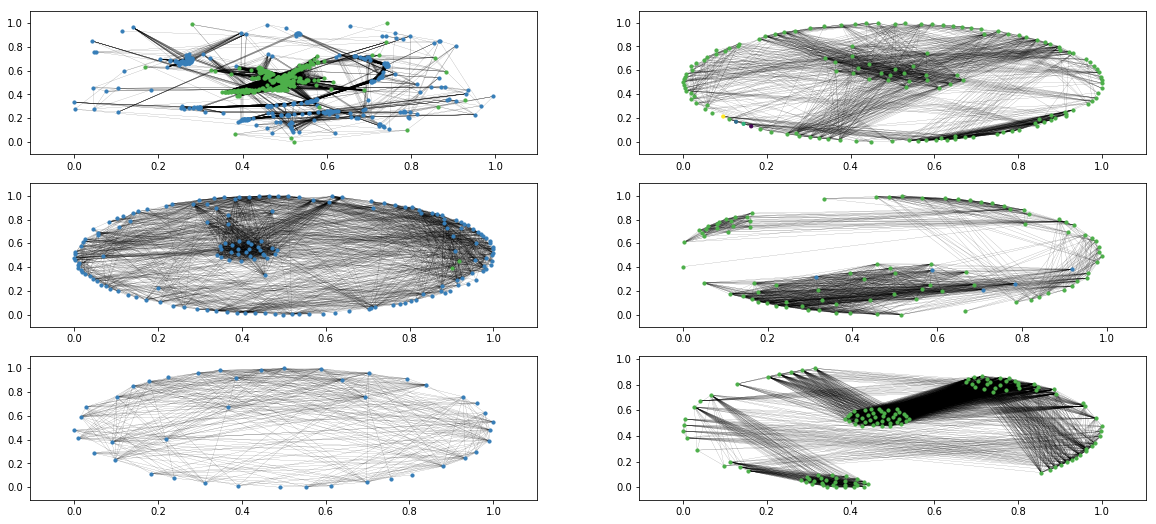

In [82]:
print("Lets visualize the bigger subgraphs we kept")
print_subgraphs_network(kept_subgraphs, reduced_satcat_df, name = "subgraph_networks_before_clique")

##### Separate the biggest graph in subgraphs

We see from the result above that most subgraphs are well separated but for the largest subgraphs.

To improve the results, we will separate the bigger subgraphs into smaller ones.

To determine how we will end the separation, we will separate the bigger graphs in cliques.

In [83]:
MAXIMUM_SUBGRAPH_NODES_PERCENT = 0.20 # How many nodes you need to be a big subgraph,
                                      # relative to the initial graph number of nodes
maximum_subgraph_nodes = int(len(graph.nodes())*MAXIMUM_SUBGRAPH_NODES_PERCENT)

# Get the index of the big subgraphs
big_subgraphs_index = get_big_subgraphs_index(kept_subgraphs,
                                              maximum_subgraph_nodes
                                             )
print(big_subgraphs_index)

[0]


In [84]:
# We will not need the initial graph anymore
del graph

We see that there's only one big subgraph in this case. Though, our methodology would apply if there was more.

In [85]:
# Segment the big subgraphs into cliques
SIZE_OF_SMALLEST_CLIQUE = 20           # Determine the minimum number of nodes in the smalles clique
                                       # i.e. no clique can have less than 20 nodes
clique_subgraphs = []
for subgraph_index in big_subgraphs_index:
    current_subgraph = kept_subgraphs[subgraph_index]
    current_subgraphs = get_graph_cliques(current_subgraph,
                                          smallest_clique=SIZE_OF_SMALLEST_CLIQUE
                                         )
    clique_subgraphs += current_subgraphs
print(get_nodes_nbr(clique_subgraphs))

[74, 357, 31, 24, 25, 29, 23, 21, 20, 22, 20]


Lets show the resulting clique subgraphs, after the big subgraph division


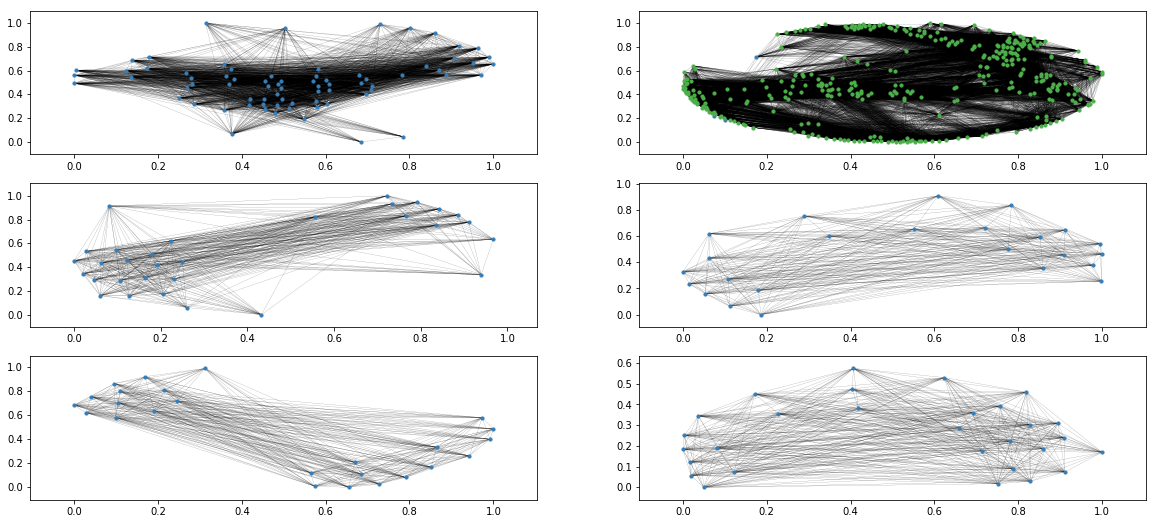

In [86]:
print("Lets show the resulting clique subgraphs, after the big subgraph division")
print_subgraphs_network(clique_subgraphs[:6], reduced_satcat_df, name = "subgraph_networks_after_clique")

We can see that nodes with different labels were effectively separated by the division into cliques.

##### Create an unified subgraph list

Now that we have many subgraphs, from the initial connected subgraphs and the clique subgraphs, 
we want to create an unified subgraph list that we will be able to use in the labelling.

In [87]:
# Construct a new subgraph without the subgraphs that where
# divided in cliques, but with the cliques
kept_subgraphs_no_big = [subgraph for index, subgraph in enumerate(kept_subgraphs)
                         if not index in big_subgraphs_index]
print(get_nodes_nbr(kept_subgraphs))
print(get_nodes_nbr(kept_subgraphs_no_big))

[670, 136, 169, 96, 43, 131]
[136, 169, 96, 43, 131]


In [88]:
# Merge the subgraphs
subgraphs = clique_subgraphs + kept_subgraphs_no_big + small_subgraphs
print(get_nodes_nbr(subgraphs))
print(sum(get_nodes_nbr(subgraphs)))
print(len(subgraphs))

[74, 357, 31, 24, 25, 29, 23, 21, 20, 22, 20, 136, 169, 96, 43, 131, 14, 6, 6, 5, 2, 6, 2, 6, 2, 2, 5, 40, 7, 2, 2, 2, 4, 2, 23, 39, 5, 2, 2, 2, 7, 2, 31, 28, 2, 2, 3, 2, 2, 2, 17, 4, 2, 4, 5, 3, 4, 8, 5, 6, 4, 27, 5, 6, 3, 10, 4]
1607
67


### Labeling of the nodes

Although we have used coloring in the graphs to show the launch site of each node, the algorithm doesn't have any information on the actual label to give to each node.

In this section, we will provide the algorithm with a subset of the nodes that have an actual label.
From there, we will try to give a probability of each subgraph to represent satellites that have been launched by a particular launch site.

We will then identify the nodes of each subgraph in bulk by using the most probable launch site.
If the probability is equal or we don't know it (i.e. we don't have any node with a label in the graph) we will identify the node launch site as "unknown".

Finally, we will compare the results with the actual 

#### Create the labeled subset of nodes

First create an array with all nodes, their label and if they were part of the labeled subset.

If they are unidentified, their label will be -1.

The label will be the the numerical value given by
num_launch_site.

In [89]:
PERCENT_OF_LABELED = 10
label_df = create_labeled_df(reduced_satcat_df, PERCENT_OF_LABELED) 
print(label_df.head(5))
print("Number of labeled sats: {}".format(label_df.is_labeled.sum()))
print("Total number of sats: {}".format(len(label_df)))

       is_labeled  label  real_label
NORAD                               
4               0     -1           1
5               0     -1           1
6               0     -1           1
9               0     -1           1
10              0     -1           1
Number of labeled sats: 174
Total number of sats: 1743


#### Calculate launch site probability of each subgraph

Depending on how many nodes where labeled in each subgraph, we will give the subgraph a probability to contain
a specific label.
Those probabilities changes depending on how many nodes where labeled

** Note: ** Subgraphs containing no identified nodes will have an empty probability dictionnary

In [90]:
subgraph_probabilities = [get_label_probs(label_df, subgraph) for subgraph in subgraphs]
print(subgraph_probabilities)

[{1: 1.0}, {2: 1.0}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {2: 1.0}, {1: 1.0}, {2: 1.0}, {1: 1.0}, {2: 1.0}, {1: 1.0}, {}, {1: 1.0}, {1: 1.0}, {}, {1: 1.0}, {}, {}, {}, {}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {}, {}, {}, {}, {}, {1: 1.0}, {1: 1.0}, {}, {}, {1: 1.0}, {}, {1: 1.0}, {}, {1: 1.0}, {}, {}, {}, {}, {}, {}, {}, {1: 1.0}, {}, {}, {}, {}, {}, {2: 1.0}, {2: 1.0}, {}, {2: 1.0}, {}, {2: 1.0}, {}, {2: 1.0}, {}, {2: 1.0}, {2: 1.0}]


#### Identify the nodes of each subgraph

Now we identify the nodes.
The subgraphs are identified in bulk, i.e. every node will have the same label.
This label the most probable in the subgraph_probabilities dictionnary.

In [91]:
label_df = identify_nodes_from_prob(label_df, subgraphs)
display(label_df.head())

is_labeled  label  real_label
NORAD                               
4               1      1           1
5               1      1           1
6               1      1           1
9               0     -1           1
10              1      1           1

In [92]:
nodes_nbr = [len(graph.nodes()) for graph in subgraphs]
sum(nodes_nbr)
print(len(nodes_nbr))
print(len(label_df))

67
1743


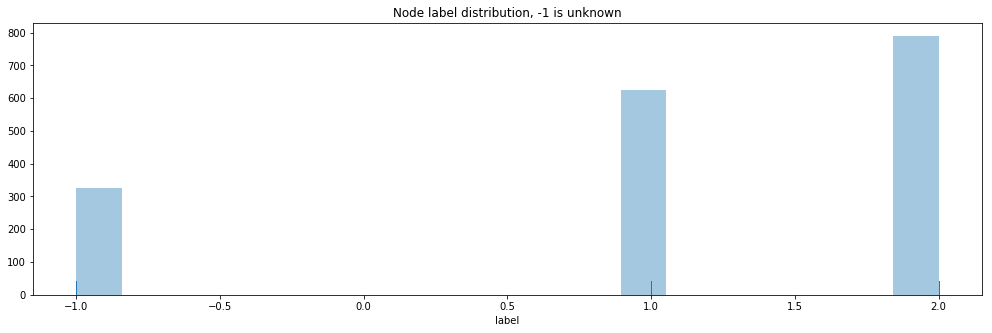

In [93]:
sns.distplot(label_df.label, kde=False, rug=True)
plt.title("Node label distribution, -1 is unknown")
plt.show()

#### Calculate the error of the labels

In the graph above, we can see that for a fixed probability of label, there's some nodes that are unknown and some that are identified.

We wan't to know what are those distributions depending on the probability we assign.

Also, we wan't to measure the error in the labels we obtained.

In [94]:
error = {}
values = range(0,101,1)
for percent_labeled in tqdm(values):
    labeled_df = get_labeled_df(reduced_satcat_df, subgraphs, percent_labeled)
    error[percent_labeled] = get_error_properties(labeled_df, reduced_satcat_df, show=False)

key_of_interest = [0, 1, 2, 5, 10, 20, 40, 60, 80, 100]
for key in key_of_interest:
    print("Fraction of labelized data: {} %, error: {}, unidentified:{}".format(key,
                                                                                error[key]["good_classification_percent"],
                                                                                error[key]["total_unknown_label"]))

100%|██████████| 101/101 [01:24<00:00,  1.20it/s]

Fraction of labelized data: 0 %, error: 0.042328042328042326, unidentified:1448
Fraction of labelized data: 1 %, error: 0.6316137566137566, unidentified:547
Fraction of labelized data: 2 %, error: 0.8159630606860159, unidentified:265
Fraction of labelized data: 5 %, error: 0.8764783180026281, unidentified:174
Fraction of labelized data: 10 %, error: 0.9302022178734507, unidentified:94
Fraction of labelized data: 20 %, error: 0.939922480620155, unidentified:83
Fraction of labelized data: 40 %, error: 0.9769182782283219, unidentified:28
Fraction of labelized data: 60 %, error: 0.9926784624771202, unidentified:6
Fraction of labelized data: 80 %, error: 0.9964391691394658, unidentified:2
Fraction of labelized data: 100 %, error: 1.0, unidentified:0


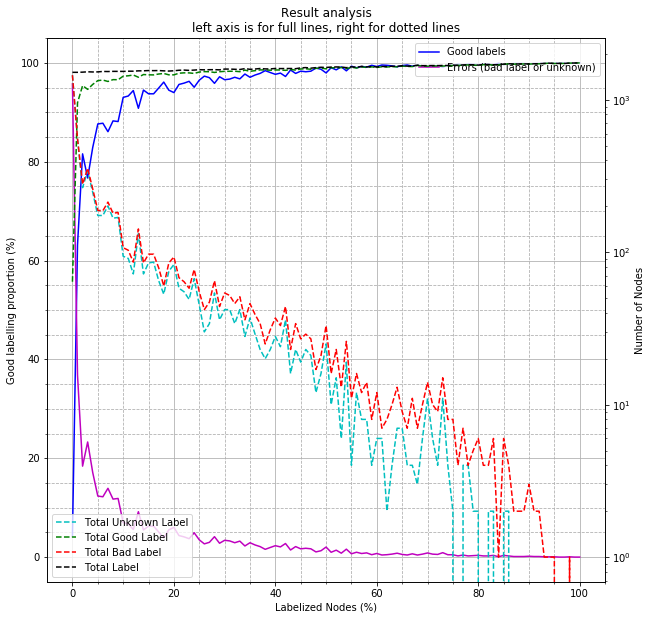

In [95]:
print_error_graph(error, "satcat_error_graph")

We can see that we obtain very few errors even with low fraction of labelized node.
From around 10% of labels we are above 90% and from around 20% of labels we are above 95%

We can see that the "Unknown" and "Bad" label decrease exponentially as we increase the fraction of labelized nodes.

In addition, the Total Label parameters gives the number of nodes that where labeled.
It is not 100%, because we don't label nodes that where not part of the random selection of pre-labelized nodes or part of the subgraphs. 
Because of this, nodes with no edges can end up not labelled.

Overall, this is a solid result and shows that in this context the clustering methodology we used was efficient.

# Conclusion
This project allowed us to use different tools learned during the course A Network Tour of Data Science to a concrete project in order to perform some analysis over acquired raw data. All the different main steps of a typical Data Science project, such as Data Acquisition, Data Exploration and Exploitation has been performed. <br>
In the first part of the project, we succeeded in clustering the different satellite orbits. We mainly observed the Low Earth Orbit, Geosynchronous and Geostationnary trajectories. <br>
In the second part, we succeeded in identifying from which launch site between the [Air Force Eastern Test Range, Florida, USA](https://en.wikipedia.org/wiki/Eastern_Range) and the [Air Force Western Test Range, California, USA](https://en.wikipedia.org/wiki/Western_Range) satellites where launch using minimal labels.<br>  

If you want more information on the subject of space missions, a [great course](http://edu.epfl.ch/coursebook/en/space-mission-design-and-operations-EE-585) is given at EPFL on the subject during the spring semester by the [astronaut Claude Nicollier](http://www.esa.int/Our_Activities/Human_Spaceflight/Astronauts/Claude_Nicollier))